In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [4]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


### Data transformation

In [6]:
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [7]:
df = df.dropna(axis=0)

In [8]:
df['clean_news'] = df['text'].str.lower()

In [9]:
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

In [10]:
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')

In [11]:
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20761, dtype: object

##### Stopwords removal

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))

In [13]:
df.head()

,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide: didn’t even see comey’s letter...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,"truth might get fired october 29, 2016 tension..."
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


### EDA

In [14]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

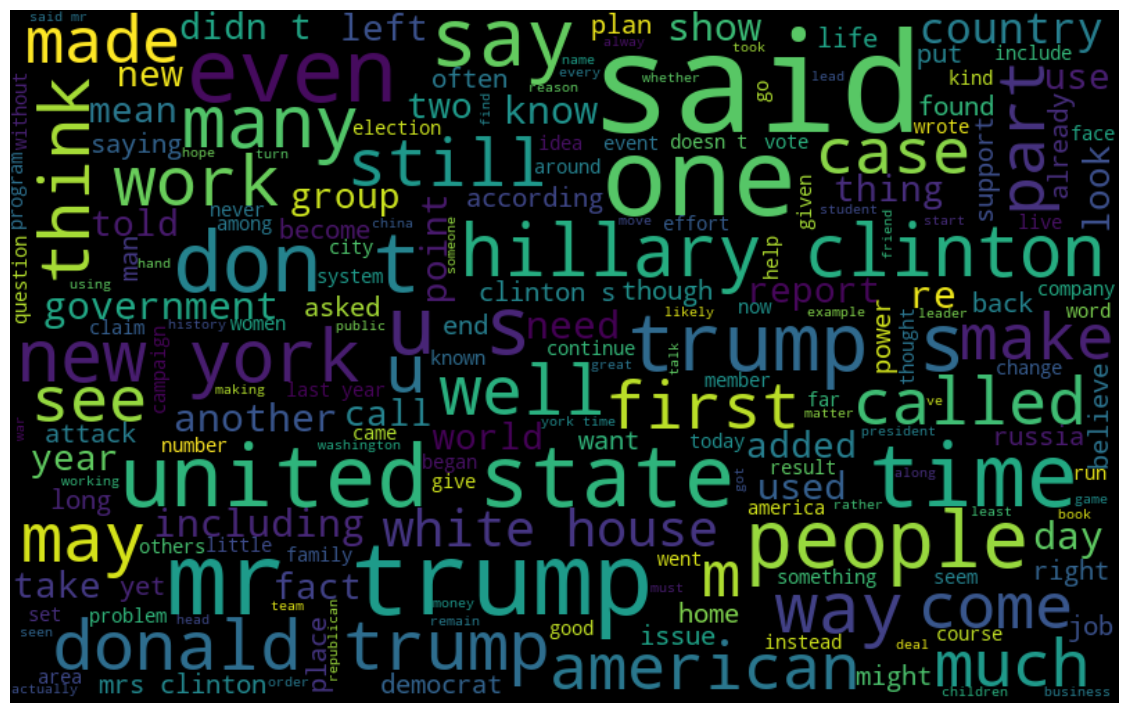

In [15]:
# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

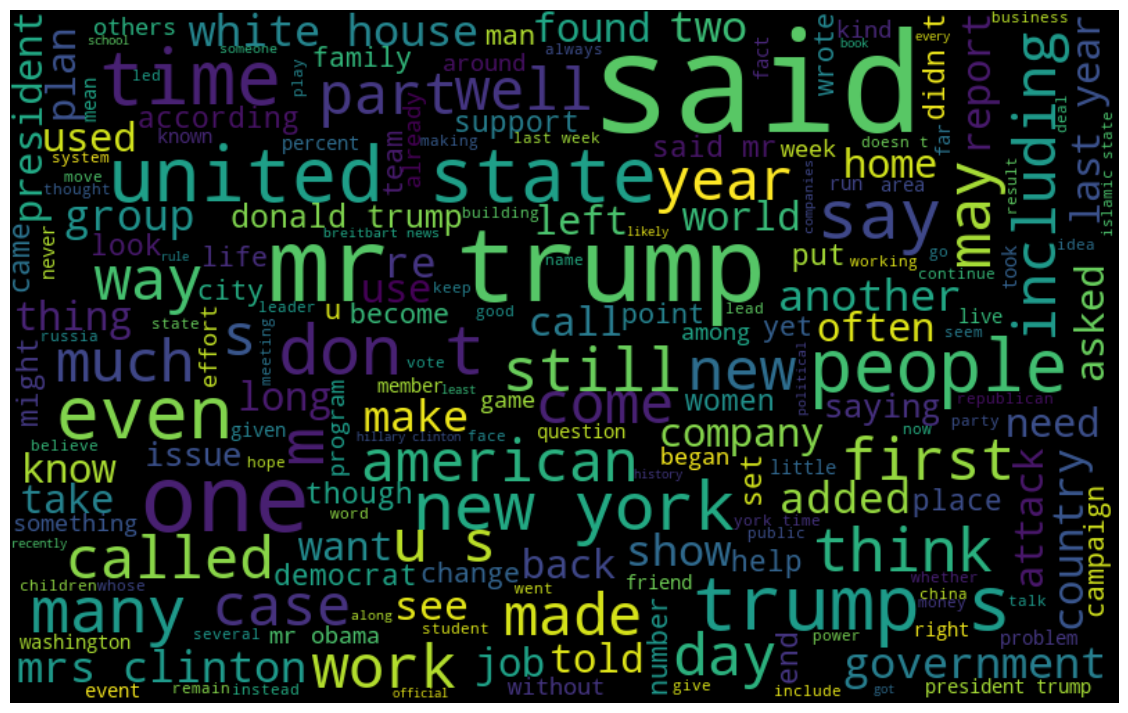

In [16]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

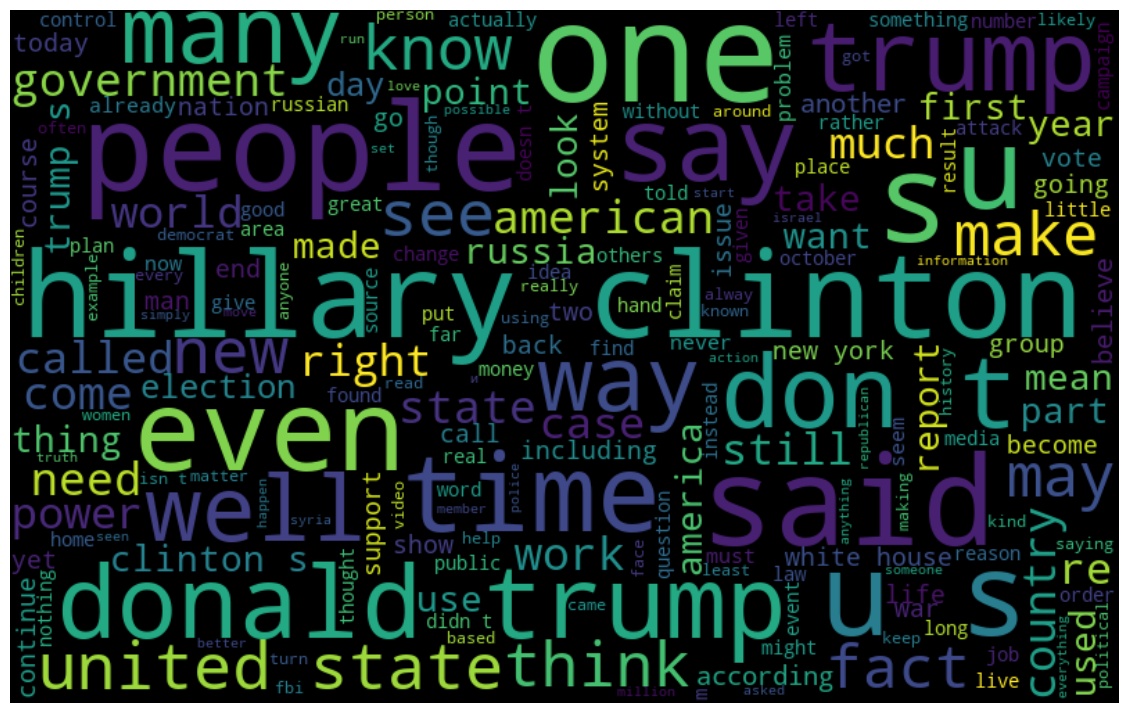

In [17]:
# visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Tokenize

In [19]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

239494

##### Padding

In [21]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

##### Word embedding

In [42]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [44]:
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Data splitting

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.15, random_state=42,
                                                    stratify=df['label'])

### Model training

In [81]:
import tensorflow as tf
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential
from tensorflow.keras.optimizers import Adam

with tf.device('/cpu:0'):
    model = Sequential([
        Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
        Dropout(0.1),
        LSTM(300),
        Dropout(0.1),
        Dense(300),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         23949500  
                                                                 
 dropout_17 (Dropout)        (None, None, 100)         0         
                                                                 
 lstm_7 (LSTM)               (None, 300)               481200    
                                                                 
 dropout_18 (Dropout)        (None, 300)               0         
                                                                 
 dense_16 (Dense)            (None, 300)               90300     
                                                                 
 dropout_19 (Dropout)        (None, 300)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                

In [82]:
with tf.device('/cpu:0'):
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics='accuracy')

In [83]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=5,            
    restore_best_weights=True,  
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,          
    patience=3,           
    min_lr=1e-6,      
    verbose=1
)

In [84]:
# train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_split=0.15,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/200
235/235 [==============================] - 27s 110ms/step - loss: 0.6472 - accuracy: 0.6266 - val_loss: 0.6735 - val_accuracy: 0.6203 - lr: 1.0000e-04
Epoch 2/200
235/235 [==============================] - 25s 107ms/step - loss: 0.6256 - accuracy: 0.6464 - val_loss: 0.6596 - val_accuracy: 0.6252 - lr: 1.0000e-04
Epoch 3/200
235/235 [==============================] - 25s 107ms/step - loss: 0.6025 - accuracy: 0.6447 - val_loss: 0.5451 - val_accuracy: 0.6925 - lr: 1.0000e-04
Epoch 4/200
235/235 [==============================] - 25s 108ms/step - loss: 0.4930 - accuracy: 0.7593 - val_loss: 0.4848 - val_accuracy: 0.7340 - lr: 1.0000e-04
Epoch 5/200
235/235 [==============================] - 25s 107ms/step - loss: 0.4787 - accuracy: 0.7654 - val_loss: 0.4735 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 6/200
235/235 [==============================] - 25s 108ms/step - loss: 0.5203 - accuracy: 0.7597 - val_loss: 0.4618 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 7/200
235/235 [=

In [85]:
# Extract accuracy and loss from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

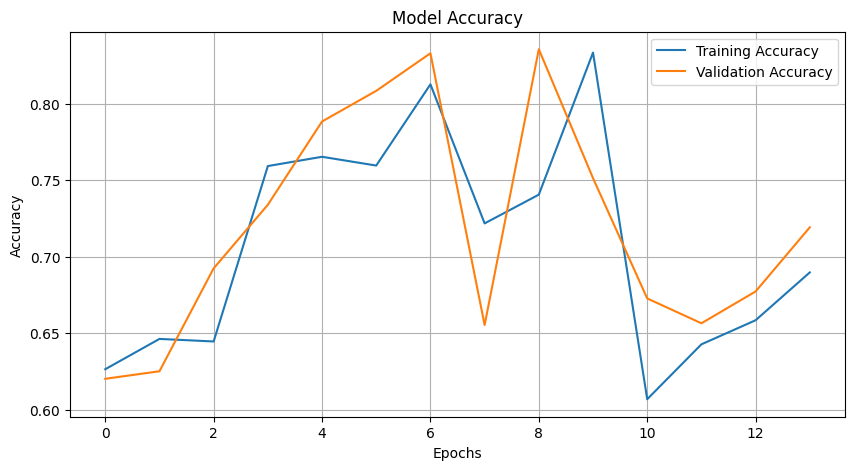

In [86]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

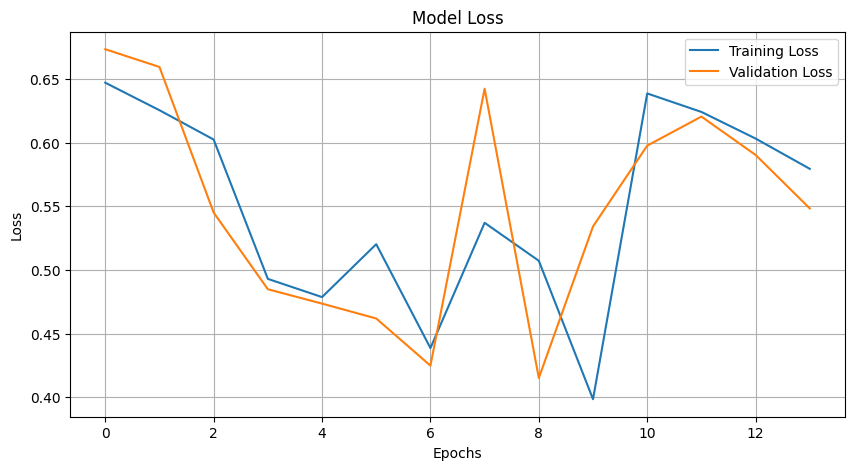

In [87]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [88]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype("int32")
#y_pred = np.argmax(y_pred, axis=1)

98/98 [==============================] - 3s 31ms/step


In [89]:
#y_true = np.argmax(y_test, axis=1)
y_true = y_test

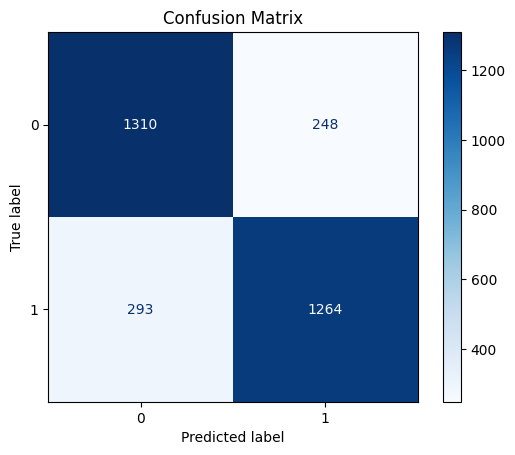

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1558
           1       0.84      0.81      0.82      1557

    accuracy                           0.83      3115
   macro avg       0.83      0.83      0.83      3115
weighted avg       0.83      0.83      0.83      3115

